In [1]:
import numpy as np
import pandas as pd
from tsfit import TSFit
import rw
import matplotlib.pyplot as plt
%matplotlib inline

This notebook gives a few functions used for plotting. These are templates meant to be updated by the user. The main (default) function tsfit_plot() explains the parameters in detail. The other functions have similar parameters.

In [2]:
def tsfit_plot(
        rwalk,
        mL,
        period,
        h=None,
        drift=0,
        plot_nodrift=False,
        t0=None,
        start_index=None,
        end_index=None,
        metric='L1',
        plot_t0_right=False,
        plot_values_right=False,
        file=None
        ):
    ''' Plots a random walk and a collection of fitted curves.
    
        Params:
        
        rwalk: the given random walk, usually from the rw module. rwalk can be a 1-dimensional numpy array,
            a pandas Series or DataFrame with a column named "values". Pandas objects must be indexed by integers.
            
        mL: a list of m-values, giving the number of EWMAs used in the individual approximations.
        
        period: the period of rwalk to be approximated. A vertical line is plotted at t0 - period (and also at t0
            if t0 is not the right edge).
            
        h: the time horizon used for the EWMAS, given in whole steps. If h=None, the optimal h will be used
        
        drift: the drift adjustment to be used.
        
        plot_nodrift: if set to True and drift != 0, then both the unadjusted and drift-adjusted approximations
                      will be plotted.
                      
        t0: the index of rwalk where the approximation is anchored. if t0=None, the highest index is used
        
        start_index: the left edge of the plot, always less than t0.
        
        end_index: the right edge of the plot, can be larger than t0.
        
        metric: what loss function to use when the error() method is called. Affects only the error() method.
        
        plot_values_right: if True, plot the rwalk to the right of t0 (set to False for future predictions)
        
        plot_t0_right: if True, plot the approximations to the right of t0 (i.e., future predictions)
        
        file: if given, save the figure
    '''
    
    if t0 is None:
        t0 = rwalk.shape[0] - 1
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = rwalk.shape[0] - 1
        
    plotdf = pd.DataFrame(rwalk, columns=['values'])
    for m in mL:
        if h is None:
            ts = TSFit(m, period=period, metric=metric)
        else:
            ts = TSFit(m, h=h, period=period, metric=metric)
        ts.fit(rwalk)
        if plot_nodrift or drift == 0:
            est = ts.transform(t0=t0)
            plotdf = plotdf.join(pd.DataFrame(est, columns=['m='+str(m)]), how='outer')
        if drift != 0:
            estdrift = ts.transform(t0=t0, drift=drift)
            plotdf = plotdf.join(pd.DataFrame(estdrift, columns=['m='+str(m)+'-drift-'+str(drift)]), how='outer')
    plotdf = plotdf.iloc[start_index:end_index+1]
    plt.figure(figsize=(12, 8))
    if plot_values_right:
        plt.plot(plotdf['values'], c='k')
    else:
        plt.plot(plotdf['values'].iloc[:t0-start_index+1], c='k')
    if plot_t0_right:
        plt.plot(plotdf.iloc[:,1:])
    else:
        plt.plot(plotdf.iloc[:t0-start_index+1,1:])
    plt.legend(plotdf.columns)
    if t0 < end_index:
        plt.axvline(t0, c='k')
    if t0 - period >= start_index:
        plt.axvline(t0 - period, c='k')
    if file is not None:
        plt.savefig(file, bbox_inches='tight')

In [3]:
def tsfit_geo_plot(rwalk, mL, period, h=None, t0=None, start_index=None, end_index=None, file=None):
    '''Same as tsfit_plot, but this function also plots the geometric Brownian Motion adjustment.
        Parameters are similar as tsfit_plot.
    '''
    if t0 is None:
        t0 = rwalk.shape[0] - 1
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = rwalk.shape[0] - 1
        
    plotdf = pd.DataFrame(rwalk, columns=['values'])
    for m in mL:
        if h is None:
            tsfit = TSFit(m, period=period)
            tsfitgeo = TSFit(m, period=period, rw_type='Geometric')
        else:
            tsfit = TSFit(m, h=h, period=period)
            tsfitgeo = TSFit(m, h=h, period=period, rw_type='Geometric')
        tsfit.fit(rwalk)
        est = tsfit.transform(t0=t0)
        plotdf = plotdf.join(pd.DataFrame(est, columns=['m='+str(m)]), how='outer')
        score = tsfit.lp_error(1)
        score2 = tsfit.lp_error(2)
        
        tsfitgeo.fit(rwalk)
        estgeo = tsfitgeo.transform(t0=t0)
        scoregeo = tsfitgeo.lp_error(1)
        scoregeo2 = tsfitgeo.lp_error(2)
        plotdf = plotdf.join(pd.DataFrame(estgeo, columns=['m='+str(m)+'-geo']), how='outer')
        print ('L1:', score, 'geoL1:', scoregeo)
        print ('L2:', score2, 'geoL2:', scoregeo2)

    plotdf = plotdf.iloc[start_index:end_index+1]
    plt.figure(figsize=(12, 8))
    plt.plot(plotdf['values'], c='k')
    plt.plot(plotdf.iloc[:,1:])
    plt.legend(plotdf.columns)
    if t0 < end_index:
        plt.axvline(t0, c='k')
    if t0 - period >= start_index:
        plt.axvline(t0 - period, c='k')
    if file is not None:
        plt.savefig(file, bbox_inches='tight')

In [4]:
def tsfit_plot_h(rw, hL, m=2, period=1000, t0=None, start_index=None, end_index=None, file=None):
    '''Plots a random walk together with approximations of different time horizons for fixed m.
        Parameters are similar to tsfit_plot. Here m is fixed and the time horizons are given as an iterable.
    '''
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = rw.shape[0] - 1
    if t0 is None:
        t0 = rw.shape[0] - 1
    
    plt.figure(figsize=(12, 8))
    for h in hL:
        tsfit = TSFit(m, h=h, period=period)
        tsfit.fit(rw)
        est = tsfit.transform(t0=t0)
        plt.plot(est[start_index:t0+1], label='h={:.4g}'.format(h))
            
    plt.plot(rw[start_index:t0+1], c='k')
    plt.axvline(t0 - period, c='k')
    plt.figtext(0.85, 0.77, 'm='+str(m))
    plt.legend()
    if file is not None:
        plt.savefig(file, bbox_inches='tight')

In [5]:
def plot_ewma(rw, m=2, h=None, period=1000, start_index=None, t0=None, file=None):
    '''plot_ewma plots the random walk together with the iterated EWMAs
        Parameters are similar to tsfit_plot
    '''
    
    if start_index is None:
        start_index = 0
    if t0 is None:
        t0 = rw.shape[0] - 1
    tsfit = TSFit(m, h=h, period=period)
    tsfit.fit(rw)
    est = tsfit.transform()
    df = tsfit.values
    plt.figure(figsize=(12, 8))
    plt.plot(df.iloc[start_index:t0+1]['values'], c='k', label='values')
    plt.plot(df.iloc[start_index:t0+1,1:])
    #plt.plot(est[start_index:t0+1], c='k', lw=2, label='estimate')
    plt.legend(df.columns)
    if file is not None:
        plt.savefig(file, bbox_inches='tight')

In [6]:
def plot_point_approx(rw, m=2, h=None, period=1000, start_index=None, file=None):
    approx = pd.DataFrame(index=rw.index, columns=['approx'])
    '''Plot the point approximations with p=period fixed (in tsfit_plot() t0 is fixed and p is variable,
        here p is fixed and t0 variable).
    '''
    if start_index is None:
        start_index = 0
    tsfit = TSFit(m, h=h, period=period, metric='P2')
    tsfit.fit(rw)
    delta = tsfit.delta()
    point_approx = (rw - delta).shift(-period)
    plt.figure(figsize=(12, 8))
    plt.plot(rwalk[start_index:], c='k', label='values')
    plt.plot(point_approx[start_index:], c='r', label='point approx')
    plt.legend()
    if file is not None:
        plt.savefig(file, bbox_inches='tight')   

In [7]:
def plot_delta(rw, m=2, h=None, period=1000, start_index=None, file=None):
    approx = pd.DataFrame(index=rw.index, columns=['approx'])
    '''Plot the 'delta', i.e., $s_n - s_{n-period}$ and its approximation.
    '''
    if start_index is None:
        start_index = 0
    tsfit = TSFit(m, h=h, period=period, metric='P2')
    true_delta = rw - rw.shift(period)
    tsfit.fit(rw)
    delta = tsfit.delta()
    plt.figure(figsize=(12, 8))
    plt.plot(true_delta[start_index:], c='k', label='delta true')
    plt.plot(delta[start_index:], c='r', label='delta approx')
    plt.legend()
    if file is not None:
        plt.savefig(file, bbox_inches='tight')   

In [8]:
trials = 3
n = 4000
tseries = np.empty(trials, dtype='object')
for i in range(trials):
    tseries[i] = rw.norm_rw(n=n)

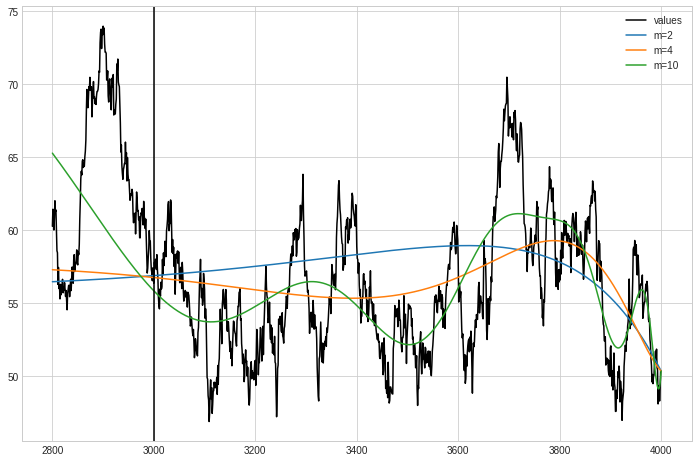

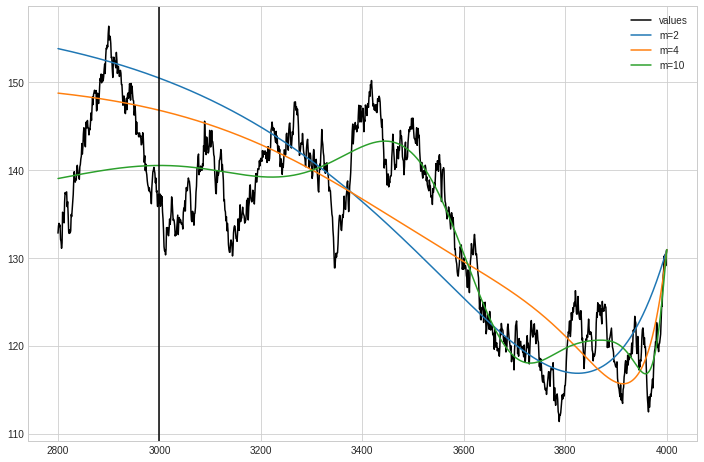

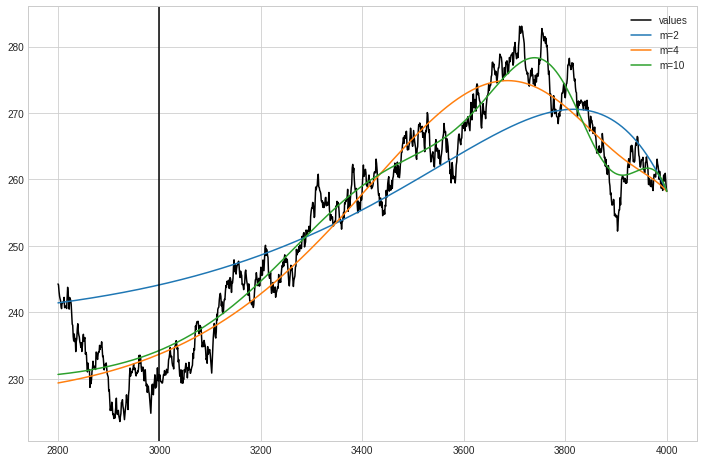

In [9]:
for i in range(tseries.size):
    tsfit_plot(tseries[i], [2, 4, 10], period=1000, start_index=2800, file='fit_'+str(i))

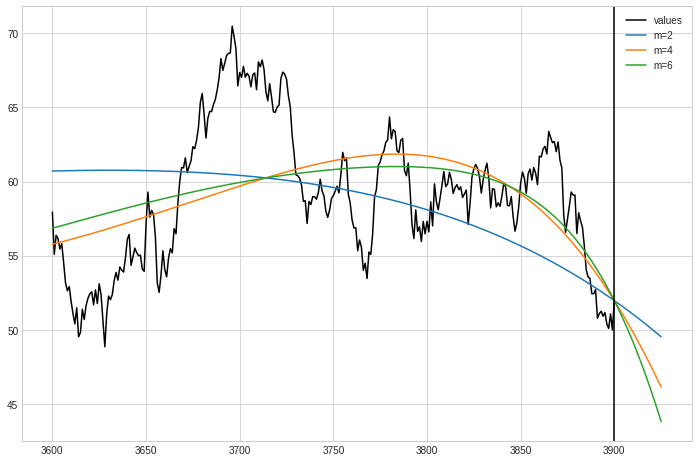

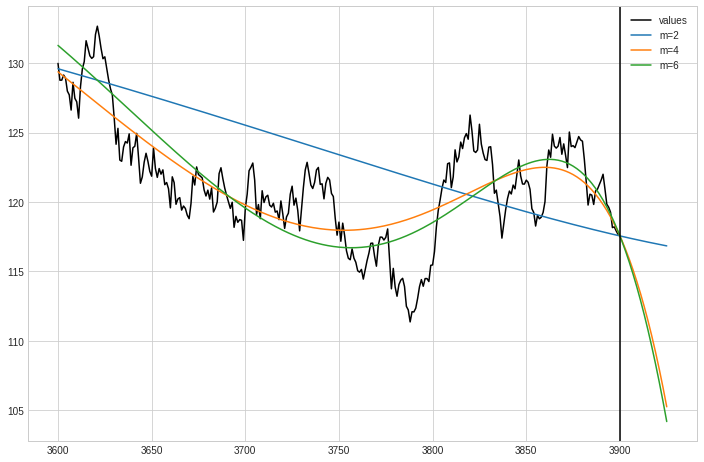

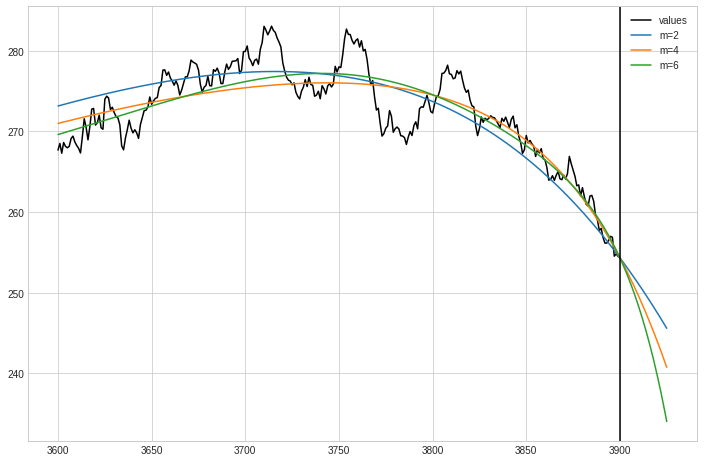

In [10]:
for i in range(tseries.size):
    tsfit_plot(tseries[i], [2, 4, 6], t0=3900, period=1000, start_index=3600,
               plot_t0_right=True, end_index=3925, file='forecast_'+str(i))

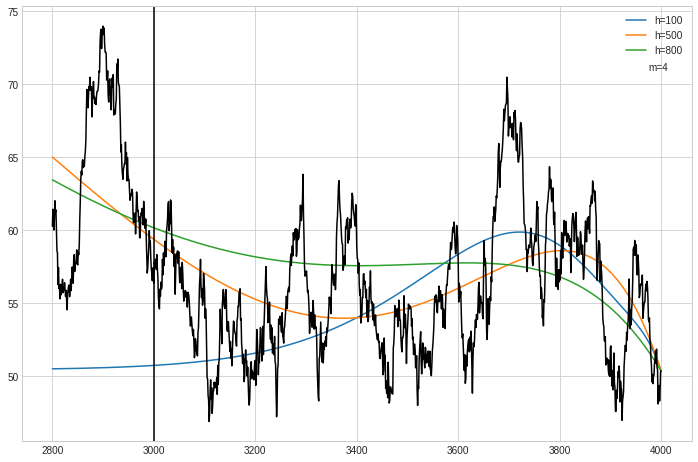

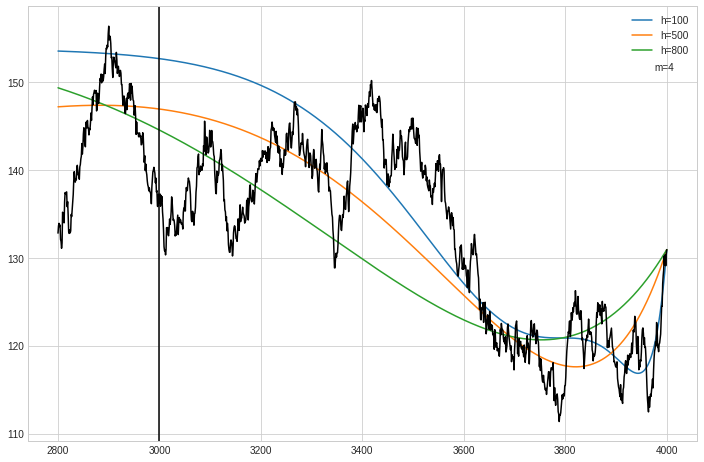

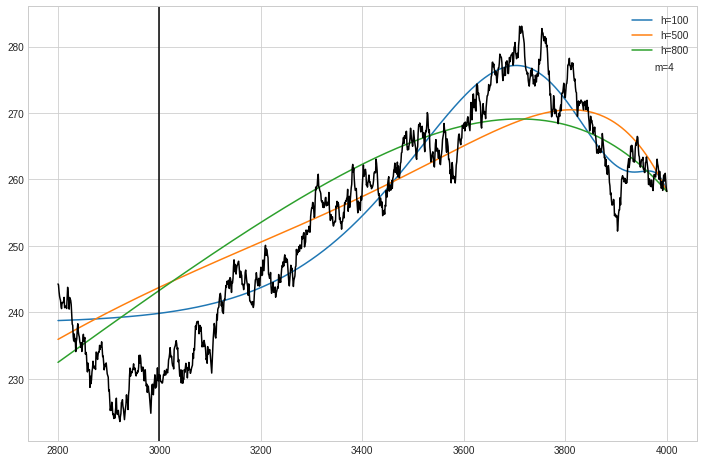

In [11]:
for i in range(tseries.size):
    tsfit_plot_h(tseries[i], hL=[100, 500, 800], m=4, start_index=2800, file='h_'+str(i))

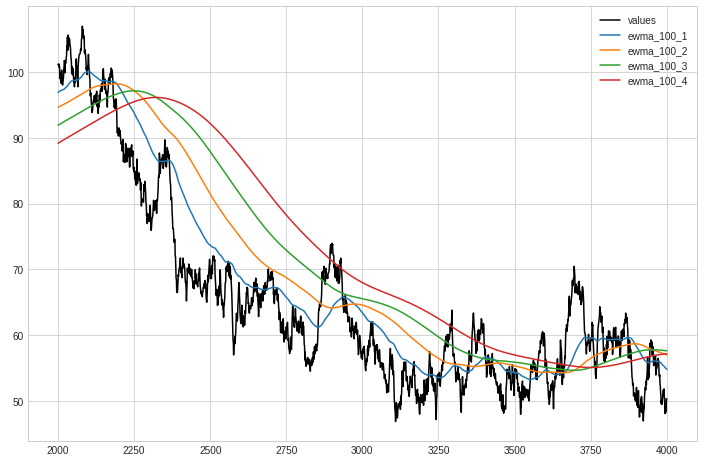

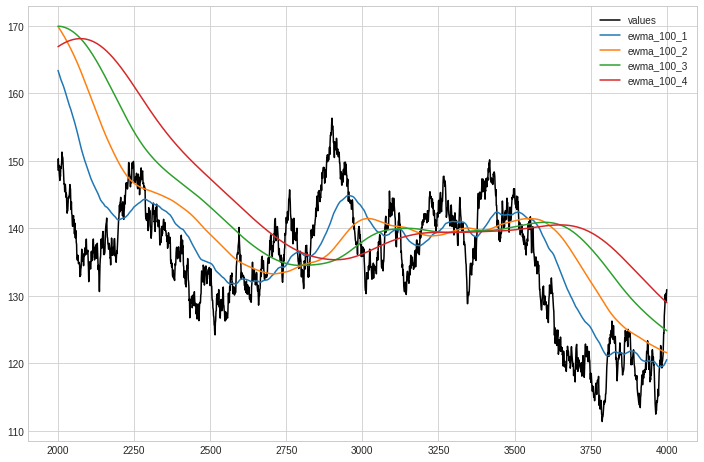

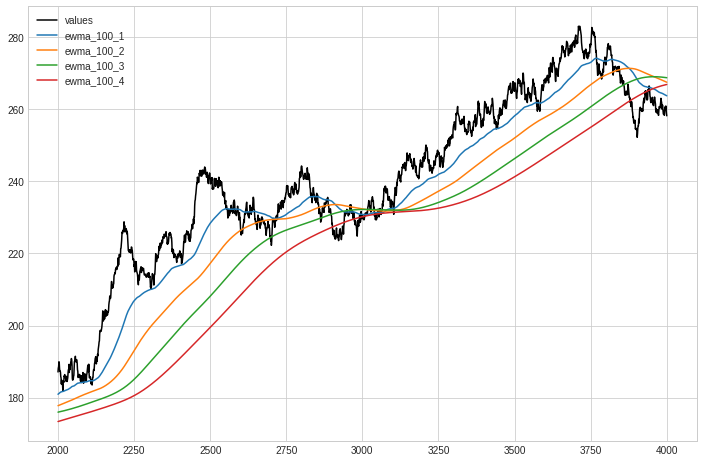

In [12]:
for i in range(tseries.size):
    plot_ewma(tseries[i], m=4, h=100, start_index=2000, file='ewma_'+str(i))

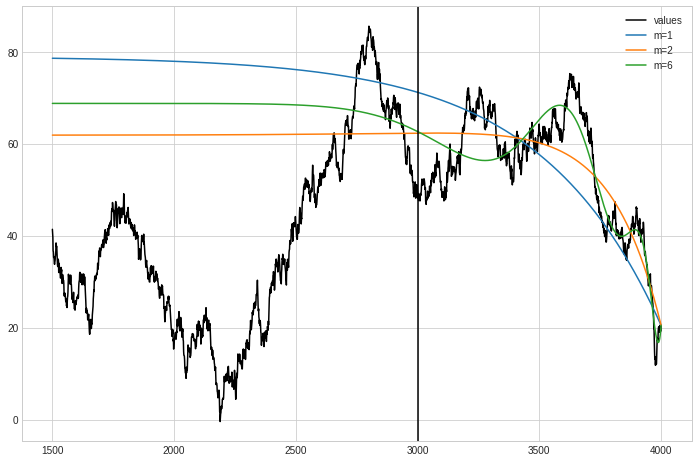

In [13]:
rwalk = rw.norm_rw(4000)
tsfit_plot(rwalk, [1, 2, 6], period=1000, start_index=1500, file='longrange')

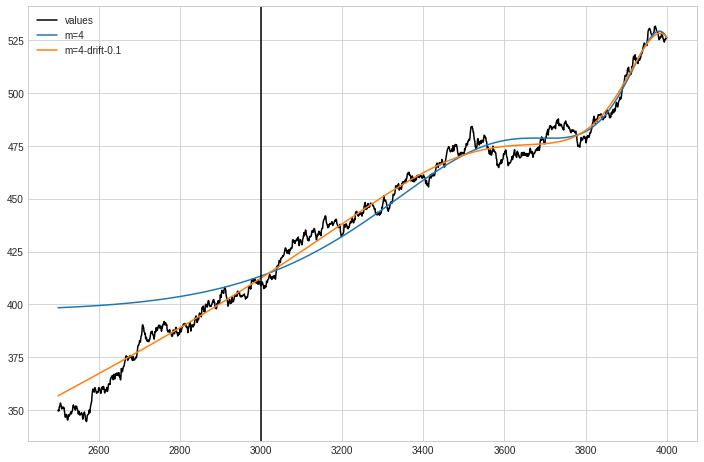

In [14]:
drift = 0.1
rwalk = rw.norm_rw(4000, drift=drift)
tsfit_plot(rwalk, [4], period=1000, drift=drift, start_index=2500, plot_nodrift=True, file='drift')

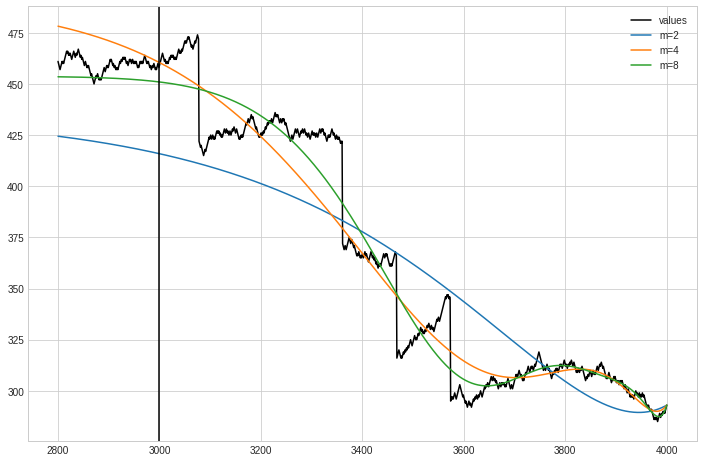

In [15]:
steps = [-50, -1, 1]
p = 0.0005
phalf = 0.5 - p/2
prob = [p, phalf, phalf]
rwalk = rw.generalized_rw(steps, prob, 4000, start_value=500)
tsfit_plot(rwalk, [2, 4, 8], period=1000, start_index=2800, file='jump')

In [16]:
print(rwalk)

0       500
1       501
2       502
3       501
4       502
       ... 
3996    289
3997    290
3998    291
3999    292
4000    293
Length: 4001, dtype: int64


L1: 3.6642826186808146 geoL1: 3.6633266124114257
L2: 4.865714525427896 geoL2: 4.919165718301816


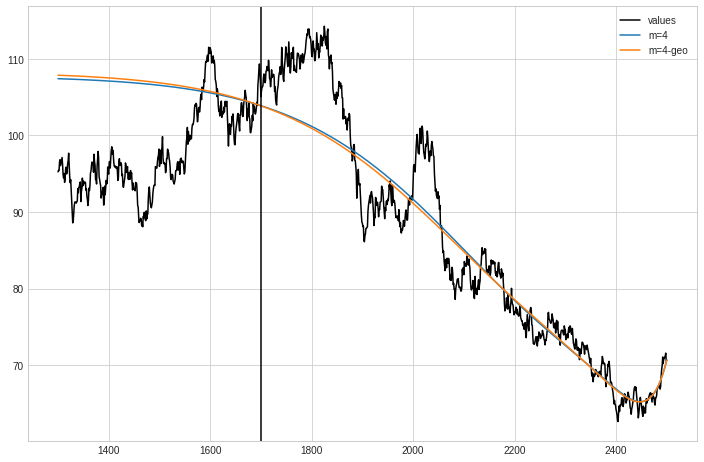

In [17]:
rwalk = rw.geo_rw(2500)
tsfit_geo_plot(rwalk, [4], period=800, start_index=1300)

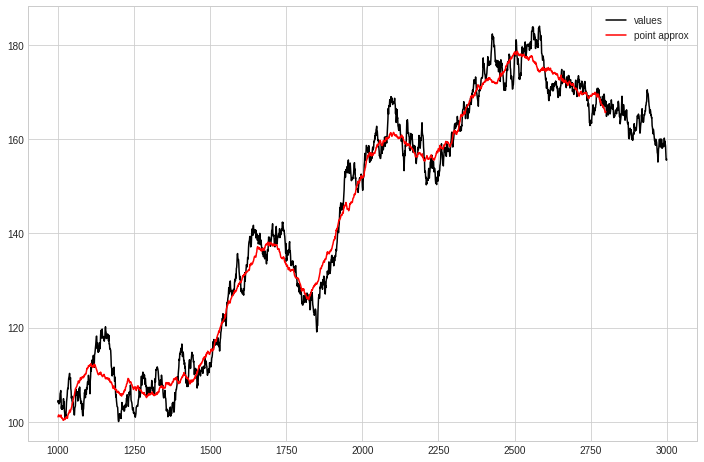

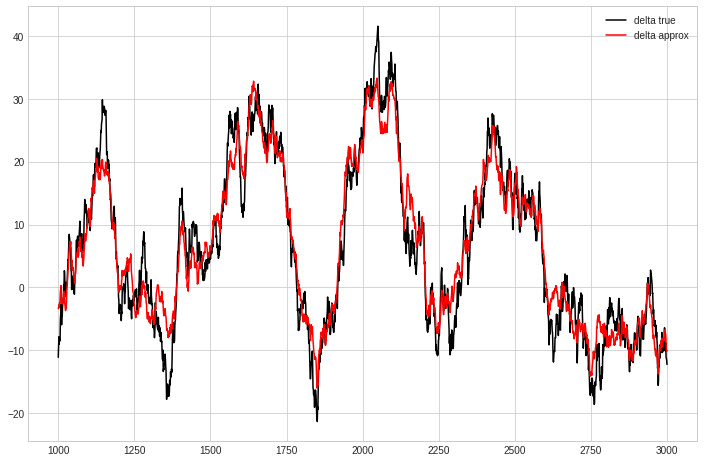

In [18]:
rwalk = rw.norm_rw(n=3000)
plot_point_approx(rwalk, m=4, period=200, start_index=1000)
plot_delta(rwalk, m=4, period=200, start_index=1000)

In [19]:
def plot_geo_delta(rw, m=2, h=None, period=1000, start_index=None, file=None):
    approx = pd.DataFrame(index=rw.index, columns=['approx'])
    '''Plot the 'delta', i.e., $s_n - s_{n-period}$ and its approximation.
    '''
    if start_index is None:
        start_index = 0
    tsfit = TSFit(m, h=h, period=period, metric='P2', rw_type='Geometric')
    true_delta = rw - rw.shift(period)
    tsfit.fit(rw)
    delta = tsfit.delta()
    plt.figure(figsize=(12, 8))
    plt.plot(true_delta[start_index:], c='k', label='delta true')
    plt.plot(delta[start_index:], c='r', label='delta approx')
    plt.legend()
    if file is not None:
        plt.savefig(file, bbox_inches='tight')   

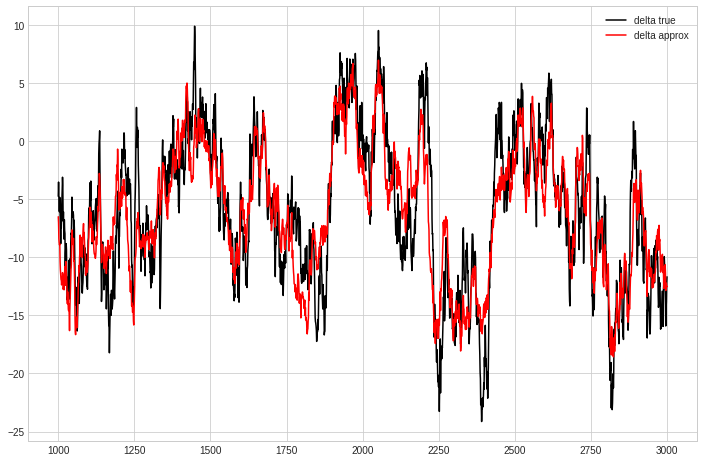

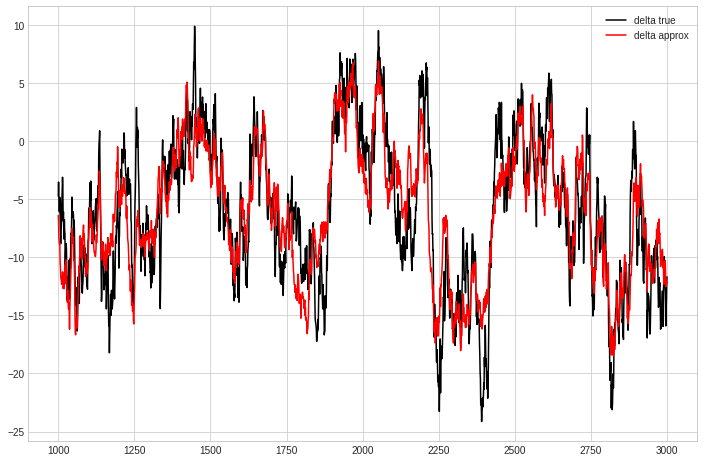

In [20]:
rwalk = rw.norm_rw(n=3000)
plot_delta(rwalk, m=4, period=200, start_index=1000)
plot_geo_delta(rwalk, m=4, period=200, start_index=1000)